# Applied Time Series

This notebook is aimed to help me and maybe you understand topics of filtering and Bayesian methods in time series better. The notebook is done in an R kernel with the aim of creating much nicer visuals than would be possible in Python with good time series data. This notebook will be a bit of an oddball as I hope to synthesize both technical exercises and details with applications as this topic is very pertinent for data scientists, quants, and everyone (hello Covid data).

The data set we will be working with is Texas county housing level data I scraped off of Texas A&M's website. The data was gathered in strings, so we had a little bit of cleaning to do.

In [40]:
# library imports
packages <- c('corrplot', 'forecast', 'lubridate', 'tidyverse')
new.packages <- packages[!(packages %in% installed.packages()[, 'Package'])]
if(length(new.packages)) {
  install.packages(new.packages)
} 
lapply(packages, require, character.only = TRUE)

getData <- function(csv_loc) {
    # :param: csv_loc - string, texas county file paths
    # :return: df - dataframe, texas county data cleaned
    
    # reading in the csvs from the data folder
    df1 <- read.csv(paste(csv_loc, 'texas_counties1.csv', sep = '/'))
    df2 <- read.csv(paste(csv_loc, 'texas_counties2.csv', sep = '/'))
    df3 <- read.csv(paste(csv_loc, 'texas_counties3.csv', sep = '/'))

    # merging the csvs by the date column
    df <- rbind(df1, df2)
    df <- rbind(df, df3)
    
    # removing commas in price data
    comma_vars <- c('dollar_vol', 'avg_price', 'med_price')
    df[, comma_vars] <- sapply(df[, comma_vars],
                               function (x) as.numeric(gsub(',', '', x)))

    # changing dates to datetime objects
    df['date'] <- lapply(as.vector(df['date']),
                         function (x) as.Date(strptime(paste('01', x, sep = ''),
                                               '%d %b %Y')))
    
    # changing all price/listing columns to numeric
    numeric_cols <- c('sales', 'dollar_vol', 'avg_price', 'med_price',
                     'total_listings', 'month_inventory')
    df[, numeric_cols] <- sapply(df[, numeric_cols], as.numeric)

    # dropping the X column - accidental indexing
    df <- df[, names(df) != 'X']
}
                         
df <- getData('data')
head(df)

Loading required package: corrplot

corrplot 0.90 loaded



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”


,date,sales,dollar_vol,avg_price,med_price,total_listings,month_inventory,county
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2011-01-01,15,1122600,74840,50000,344,31.0,Anderson
2,2011-02-01,20,1652300,82615,66950,371,30.1,Anderson
3,2011-03-01,25,3013550,120542,92000,372,27.1,Anderson
4,2011-04-01,25,2733350,109334,115000,365,24.1,Anderson
5,2011-05-01,27,2239161,82932,70000,387,23.8,Anderson
6,2011-06-01,21,1798605,85648,78000,421,23.9,Anderson


## About the Data and our Problem

Filtering and the problem of prediction in machine-learning go hand in hand. In this particular case, I believe our goal is to predict the average price column for the next quarter (3 months). This problem is tangible and relevant as if we can predict the average price for the next three months in a variety of Texas counties, then we have a great chance of being able to lever up and flip properties in the short-term picture - an interesting way of accruing wealth. Of course, this data set is simplified in the sense that I only include a few relevant variables - to spin this into your own personal project, consider adding macroeconomic variables that are indexed by quarter and month as well as more microeconomic variables like education level, companies in the city, average education level, etc!

Now first, it is sensible to perform some exploratory data analysis (EDA) to gain a sense of how exactly we should predict home prices (I will just cover filtering however).

Warning message:
“Removed 2 rows containing missing values (geom_point).”


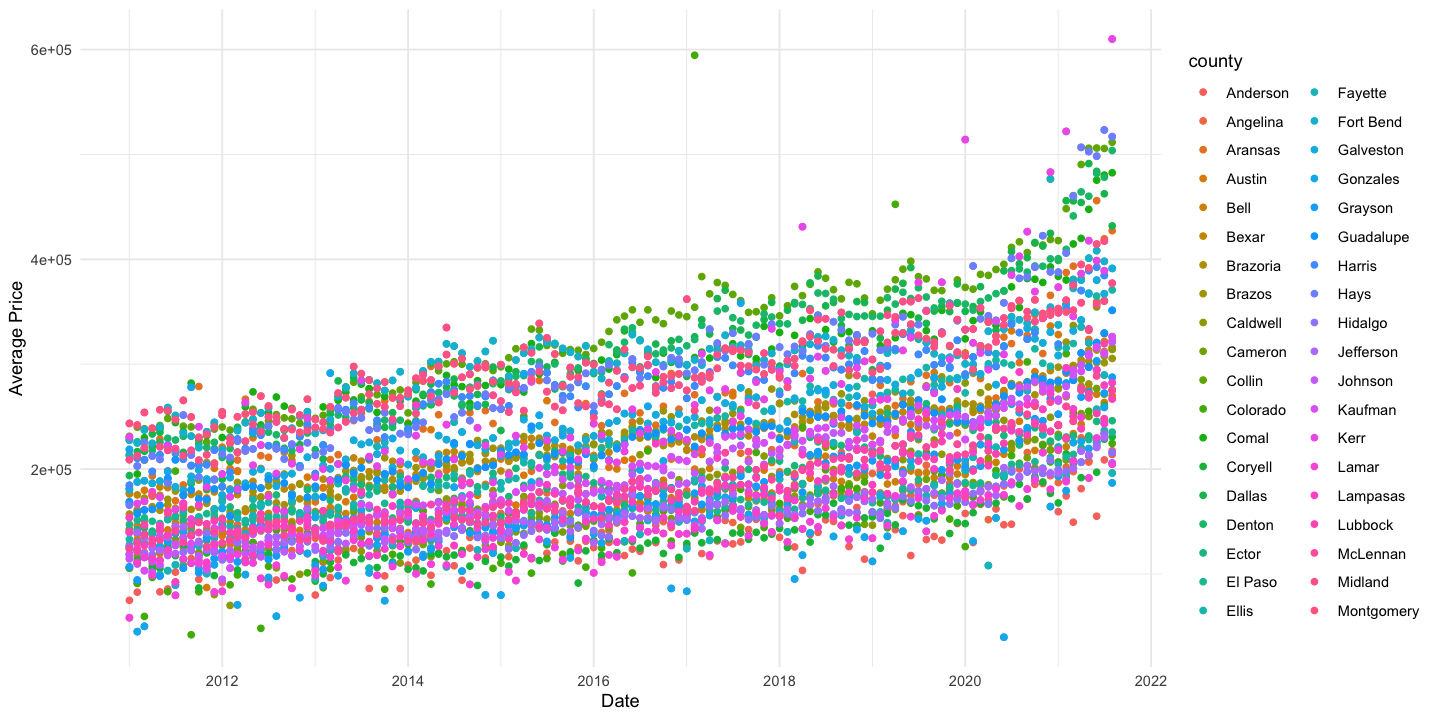

In [2]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(data = df) +
geom_point(aes(x = date, y = avg_price, color = county)) +
labs(x = 'Date', y = 'Average Price') + theme_minimal()

There's a noticeable linear trend with respect to time of our county data. Another interesting aspect is the fairly large dispersion among counties for average price - there are a few outliers on the positive end (that point in 2017 from Colorado county) and a few on the positive and negative bands as we enter Covid where the housing dynamic across the nation experienced a phase change. As a side note, I would be curious if the time series has any cyclical bits - are home prices generally higher in the spring and come back down in the winter? Well, we plot that below and underwhelmingly there is very little change. If desirable, we could construct a hypothesis test of sorts to compare the data (a simple LRT or Wald test could suffice as data is sufficiently large).

Warning message:
“Removed 4771 rows containing non-finite values (stat_boxplot).”


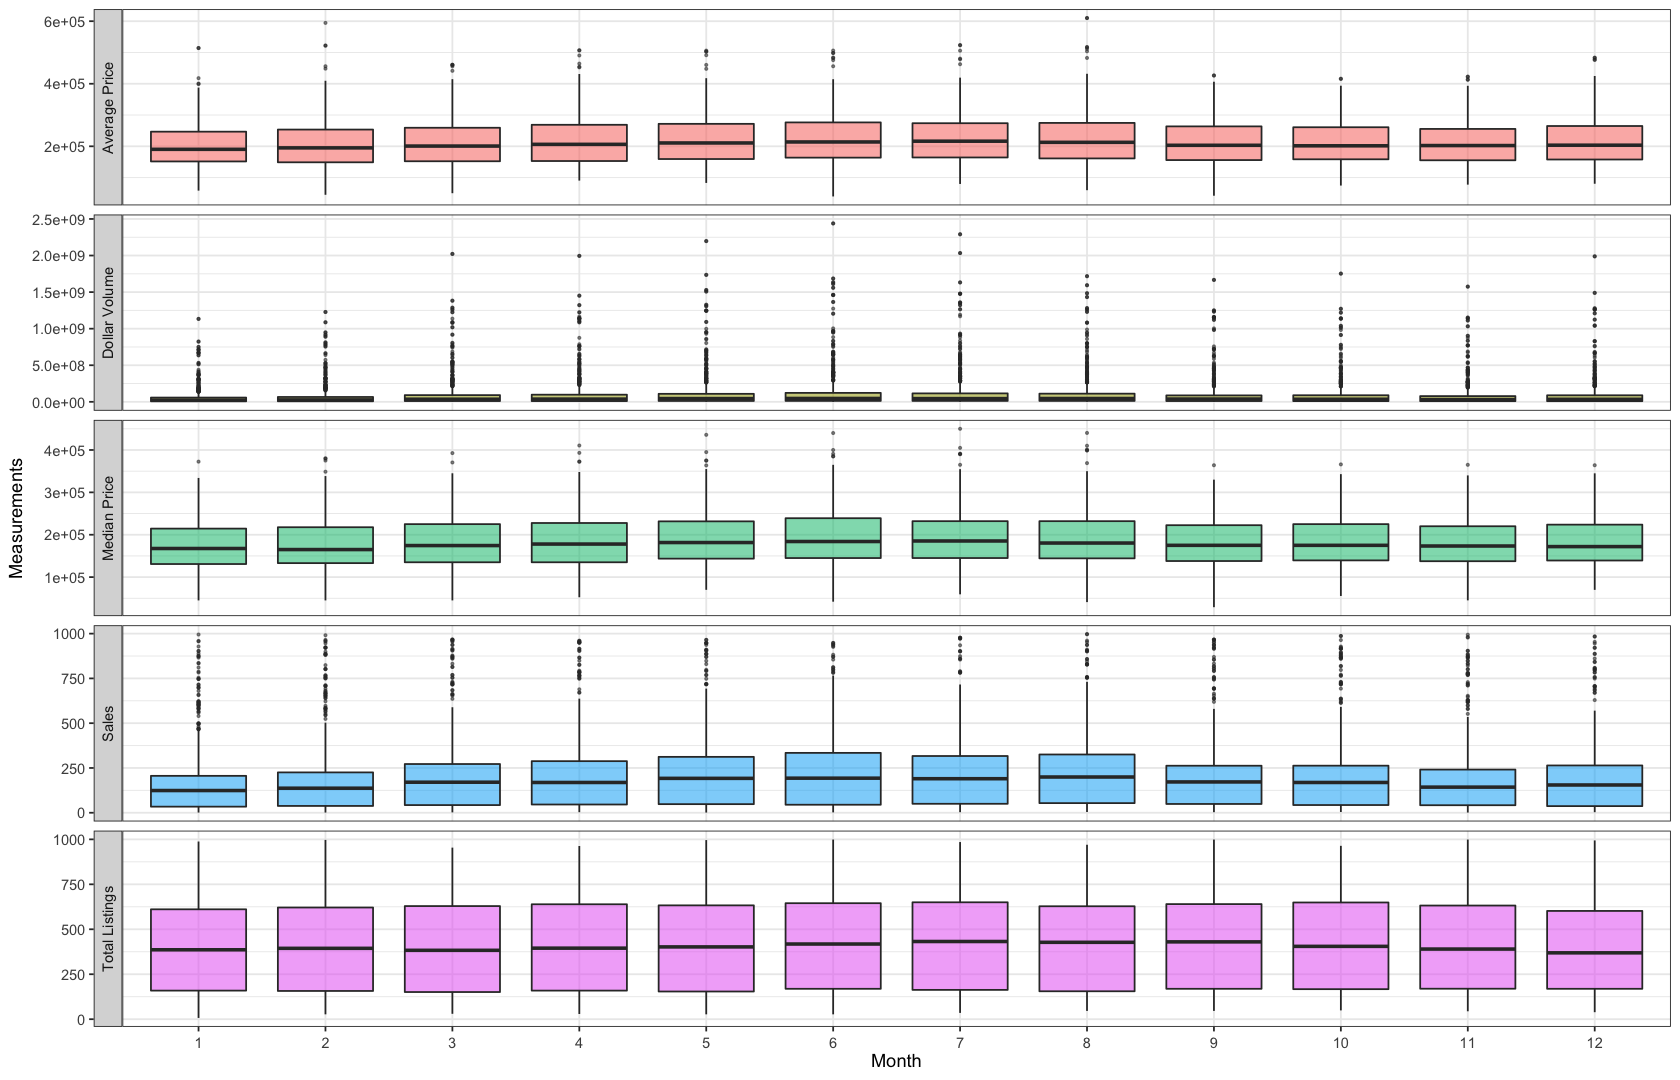

In [3]:
options(repr.plot.width = 14, repr.plot.height = 9)
df %>%
    mutate(month = factor(month(date))) %>%
    select(sales, dollar_vol, avg_price, med_price, total_listings, month) %>%
    gather('type', 'value', -c('month')) %>%
    ggplot() +
    geom_boxplot(aes(x = month, y = value, group = month, fill = type, alpha = 0.7),
                 outlier.size = 0.5) +
    labs(x = 'Month', y = 'Measurements', fill = 'Date') +
    scale_color_manual(values = c('sales' = '#80B1D3',
                                  'dollar_vol' = '#8DD3C7',
                                  'avg_price' = '#FDB462',
                                  'med_price' = '#FB8072',
                                  'total_listings' = '')) +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 0, vjust = 0.5),
        legend.position = 'None') +
  facet_grid(rows = vars(type), 
             scales = 'free', 
             switch = 'y',
             labeller = as_labeller(c(`sales` = 'Sales',
                                      `dollar_vol` = 'Dollar Volume',
                                      `avg_price` = 'Average Price',
                                      `med_price` = 'Median Price',
                                      `total_listings` = 'Total Listings')))

In [4]:
summary(df)

      date                sales         dollar_vol          avg_price     
 Min.   :2011-01-01   Min.   :  1.0   Min.   :4.500e+04   Min.   : 39667  
 1st Qu.:2013-08-01   1st Qu.: 43.0   1st Qu.:9.848e+06   1st Qu.:156223  
 Median :2016-04-01   Median :163.0   Median :3.590e+07   Median :204636  
 Mean   :2016-04-14   Mean   :212.2   Mean   :1.241e+08   Mean   :215287  
 3rd Qu.:2018-12-01   3rd Qu.:282.0   3rd Qu.:9.474e+07   3rd Qu.:263978  
 Max.   :2021-08-01   Max.   :997.0   Max.   :2.439e+09   Max.   :610047  
                      NA's   :866     NA's   :2           NA's   :2       
   med_price      total_listings  month_inventory     county         
 Min.   : 29000   Min.   :  7.0   Min.   : 0.300   Length:7290       
 1st Qu.:138000   1st Qu.:162.0   1st Qu.: 2.500   Class :character  
 Median :175000   Median :400.0   Median : 3.500   Mode  :character  
 Mean   :184732   Mean   :416.3   Mean   : 4.372                     
 3rd Qu.:225574   3rd Qu.:631.0   3rd Qu.: 5.175  

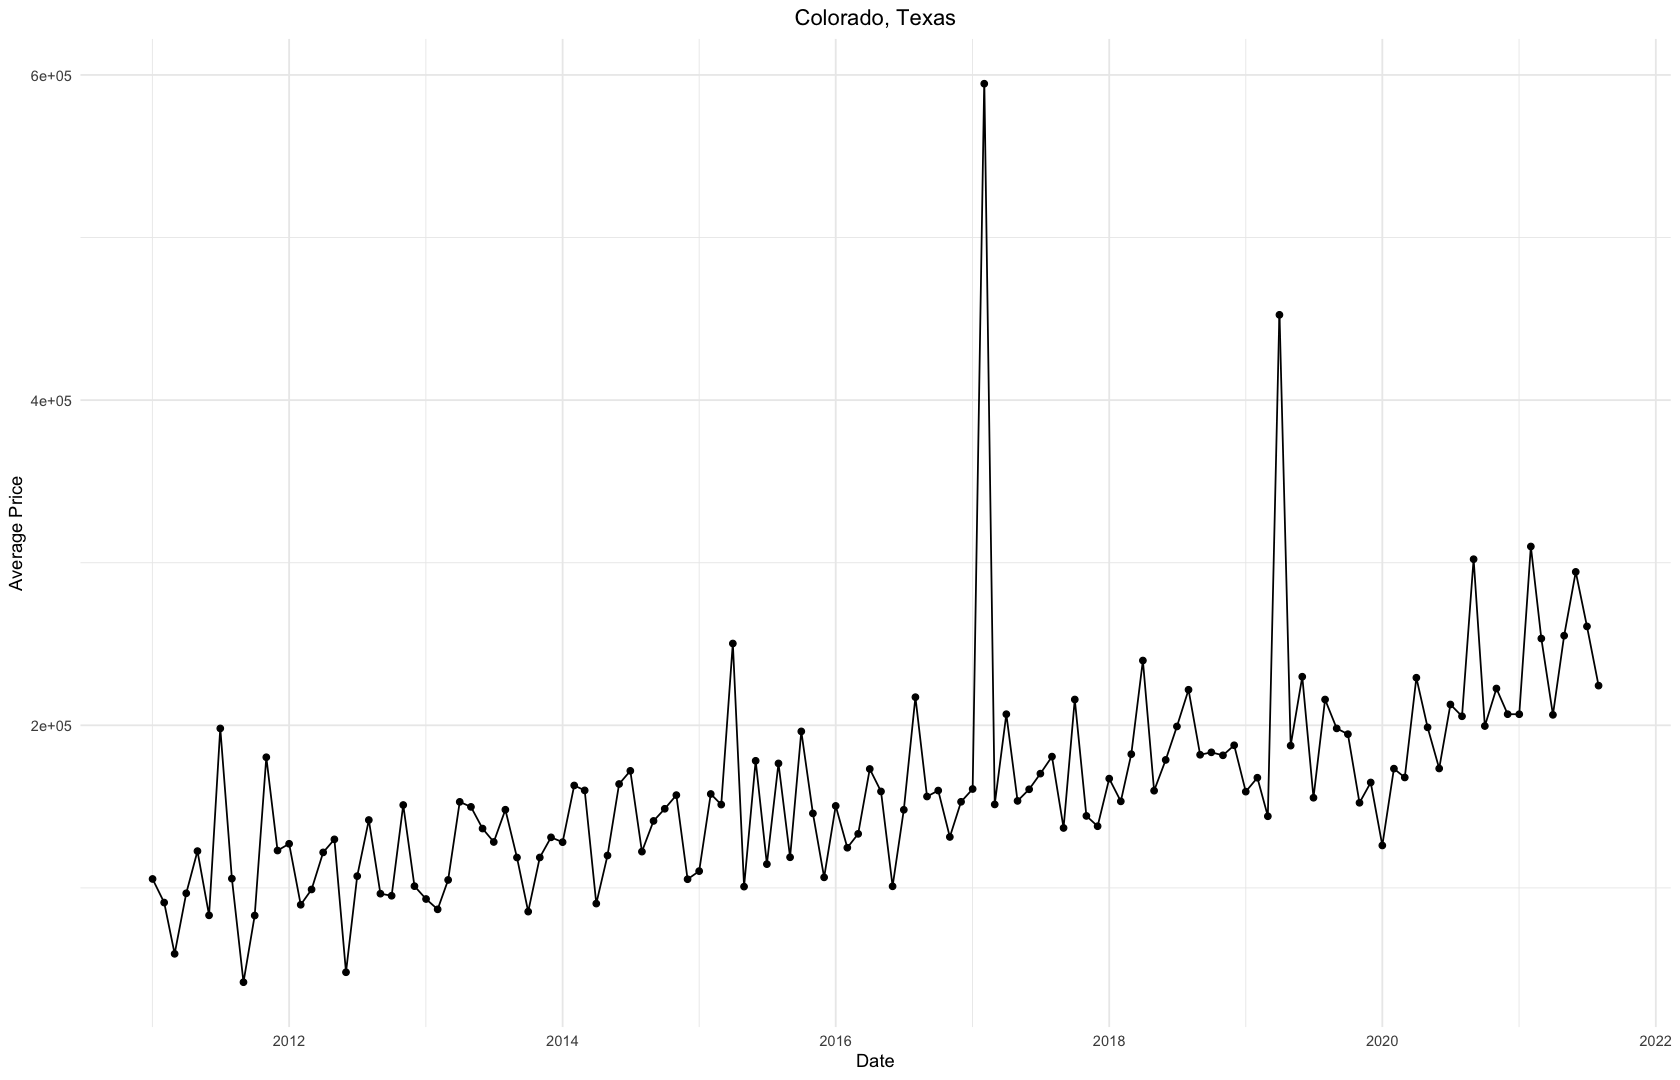

In [5]:
# state with outliers - some ugly place without local government
ggplot(data = df %>% filter(county == 'Colorado'), aes(x = date, y = avg_price)) +
geom_point() +
geom_line() +
labs(x = 'Date', y = 'Average Price', title = 'Colorado, Texas') +
theme_minimal() +
theme(plot.title = element_text(hjust = 0.5))

This place is causing a rucus with the instability of prices - on the Wikapedia page, it says that this particular county is unincorporated - meaning that there is no local government. I think that could add some color as to why the prices here are pretty unstable over time. For filtering, I say we exclude this. Now time to pivot to the actual filtering and math...

# State Space Formulation

## Key Definitions & Theorems

### State Space Model:

- Definition 1 (Gelb): **rephrase this** My words: basically we have a $N$th order differential equation and we can write the system in matrix notation along with perturbations/noise/etc.

- Definition 1 (Chopin): A state-space model is a time series model that consists of two discrete stochastic processes $\{X_t\}=(X_t)_{t\geq 0}$ and $\{Y_t\}=(Y_t)_{t\geq 0}$ taking values in spaces $\mathcal{X}$ and $\mathcal{Y}$ respectively. (This is a very loose definition - not very mathematical).

- Definition 2 (Chopin): Let us consider again two sequences of random variables $(X_t)_{t\geq 0}$ and $(Y_t)_{t\geq 0}$ such that:

$$X_0 = K_0(U_0,\theta)$$

$$X_t = K_t(X_{t-1},U_t,\theta),\;\; t\geq 1$$

$$Y_t=H_t(X_t,V_t,\theta),\;\; t\geq 0$$

where $K_0$, $K_t$, $H_t$ are deterministic functions, and $\{U_t\}$, $\{V_t\}$ are sequences of i.i.d random variables. 

### Example of State Space Models:

Here I would like to handpick some examples mentioned in the two books for state space models as well as work out a few problems from Gelb.

- Example 1: Physics

- Example 2: Periodic Random Walk

# Modelling Variance of Home Prices

In real-estate and finance, we often times are concerned with the variance of prices as many investors prefer steady, low-variance inflows of cash over time. However, unlike in textbooks - variance is not constant over time. Variance expands during downturns or periods of panic - COVID, 2008 financial crisis, etc. This can be seen through the following visuals of Austin, Texas over the course of the past 12 or so years. Look at years 11-12 (the past two years) where we see pockets of obscene variance in home prices in relation to the past decade. 

With this in mind, we can go about modeling volatility of home prices in two classes I will cover. The first class assumes that there are many unobservable and unpredictable features from which we decidedly model volatility as a stochastic process. The second class of models coincides more in line with Bayesians where we understand certain market-regime shifts and update volatility in accordance with our beliefs - akin to change-point, Monte Carlo (Gibbs sampling in particular). 

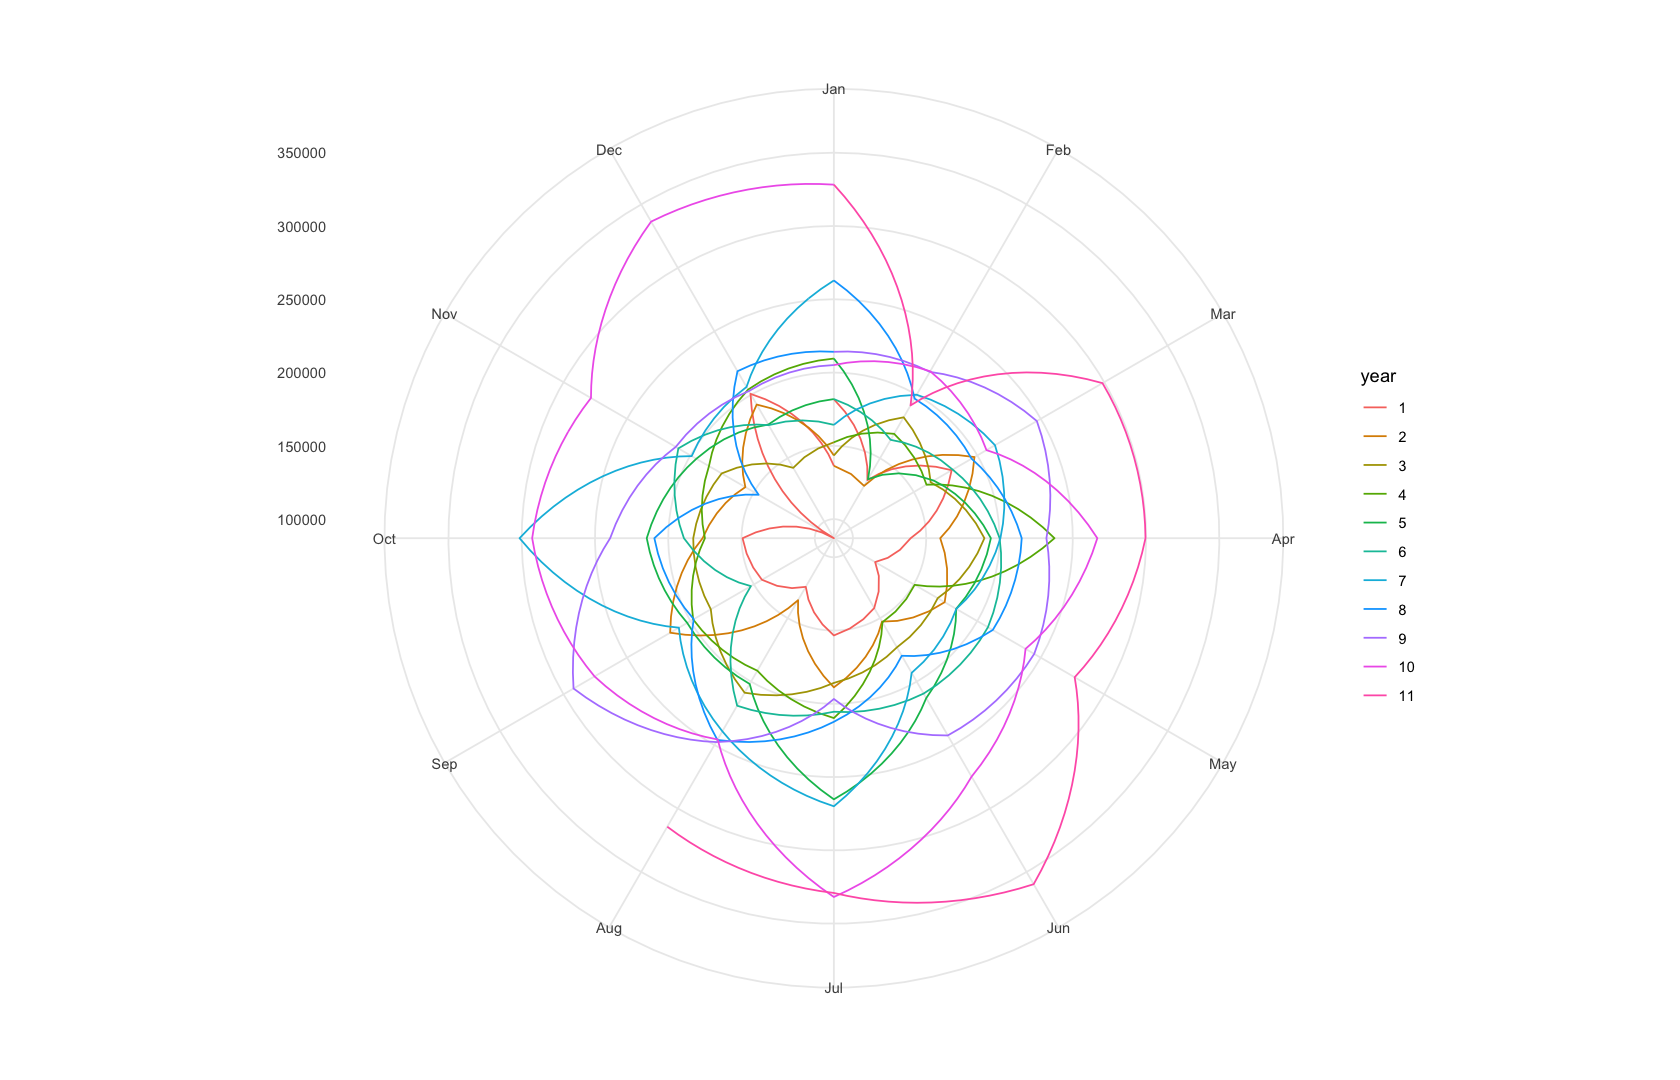

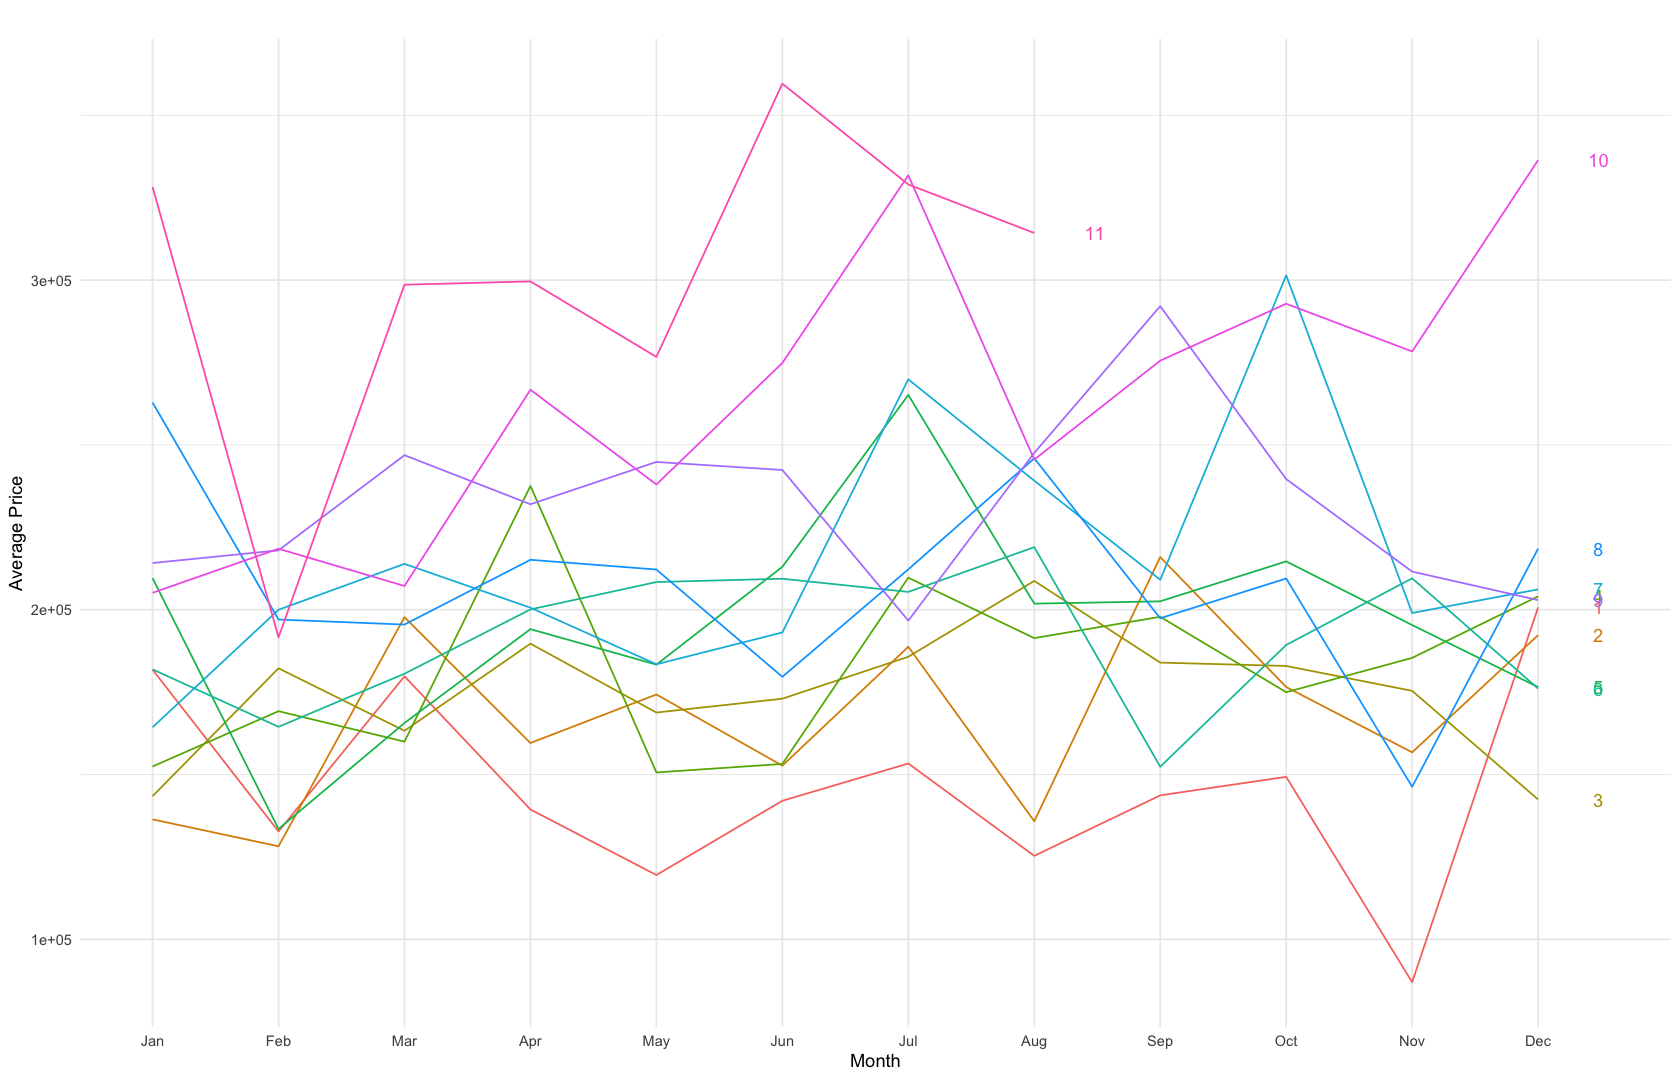

In [28]:
# pulling out a county with a lot of variance 
austin_prices <- df %>% filter(county == 'Austin') %>% select('avg_price')
austin_ts <- ts(austin_prices, frequency = 12)

# circular annual plot
ggseasonplot(austin_ts, polar = TRUE, main = '', xlab = '') +
theme_minimal()

# unstacked annual plot
ggseasonplot(austin_ts, year.labels = TRUE, main = '', ylab = 'Average Price') +
theme_minimal()

## Stochastic Volatility 

A good data scientist will be able to blend intuition, expert opinions, and exploratory analysis of the data into a judgement call for the type of model that best suits the data. In our case, I believe that a stochastic volatility model for the entire class of counties is naive as some counties in Texas are much more agricultural while counties like Austin are experiencing inflows due to tech and finance alike. With that said, I think the latter class of models - Bayesian change-point models are much easier to justify to clients than this approach. However, the goal of this notebook is to survey these topics together so down the line, you may find this particular naive model more suitable for your problem.

For starters, we will consider the simplistic GARCH model. But first, let us introduce two concepts from stochastic processes that will provide us some insight into the innerworkings of the model.

### Martingale

- Definition 1: A stochastic process $\{S_t\}_{t\in\tau}$ is a **martingale** with respect to another stochastic process $\{X_t\}_{t\in\tau}$  if for all $t$, we have

**1)** $\mathbb{E}(|S_t|)<\infty$

**2)** $\mathbb{E}\left(|S_t||X_1,\dots,X_{t-1}\right)=S_{t-1}$

A martingale is a fair game - i.e. consider a sequence of tosses of the fair coin where we define $X_t$ to be binary where heads is assigned the value 1 and tails the value -1 and $S_t=\sum_1^t X_i$. Then clearly 

$$\mathbb{E}(S_t)=\mathbb{E}\left(\sum\limits_{i=1}^t X_i\right)=\mathbb{E}(X_1)+\cdots +\mathbb{E}(X_{t-1})=0<\infty$$

and prior flips of the coin do not lend us intuition for the next roll, so the conditonal expectation is

$$\mathbb{E}\left(S_t|X_1,\dots,X_{t-1}\right)=\mathbb{E}\left(S_{t-1}+X_t\right)=S_{t-1}+\mathbb{E}(X_t)=S_{t-1}.$$

As a non-example of a martingale, consider rather the sequence of tosses where $X_t$ is assigned the value 1 for heads and 0 for tails. Then $\mathbb{E}(S_t)\nless\infty$ as it is binomial, so $np\rightarrow\infty$ as $n\rightarrow\infty$. 

- Definition 2: A stochastic process $\{X_t\}_{t\in\tau}$ is a **martingale difference sequence** if for all $t$, we have that

**1)** $\mathbb{E}(X_t)<\infty$

**2)** $\mathbb{E}\left(X_t|X_1,\dots,X_{t-1}\right)=0$ almost surely

Any martingale can be turned into a martingale difference sequence if we define $Y_t=X_t-X_{t-1}$. Notice that the prior coinflip example could be an example if we let $D_t=S_t-S_{t-1}$ or we could also consider the coinflip stochastic process $\{X_t\}_{t\in\tau}$ as a martingale difference sequence without looking at the sum of heads and tails if our coin is fair, so $\mathbb{P}(\text{heads})=\frac{1}{2}$, as then $\mathbb{E}(X_t)=0$ and 

$$\mathbb{E}\left(X_t|X_1,\dots,X_{t-1}\right)=\mathbb{E}(X_t)=0.$$

- Definition 3: A **GARCH(p, q) model** is a margingale difference sequence $\{Y_t\}_{t\in\tau}$ such that for all $t$, we have

$$y_t=\sigma_t\epsilon_t$$

where $\epsilon_t\sim\mathcal{N}(0,1)$ and 

$$\sigma_t^2=a_0+\sum\limits_{i=1}^p a_i\sigma_{i}^2+\sum\limits_{j=1}^q b_j\epsilon_j^2$$

for a sequence of constants $a_0,\dots,a_p$ and $b_1,\dots,b_q$ from some field of numbers - i.e. the reals. 


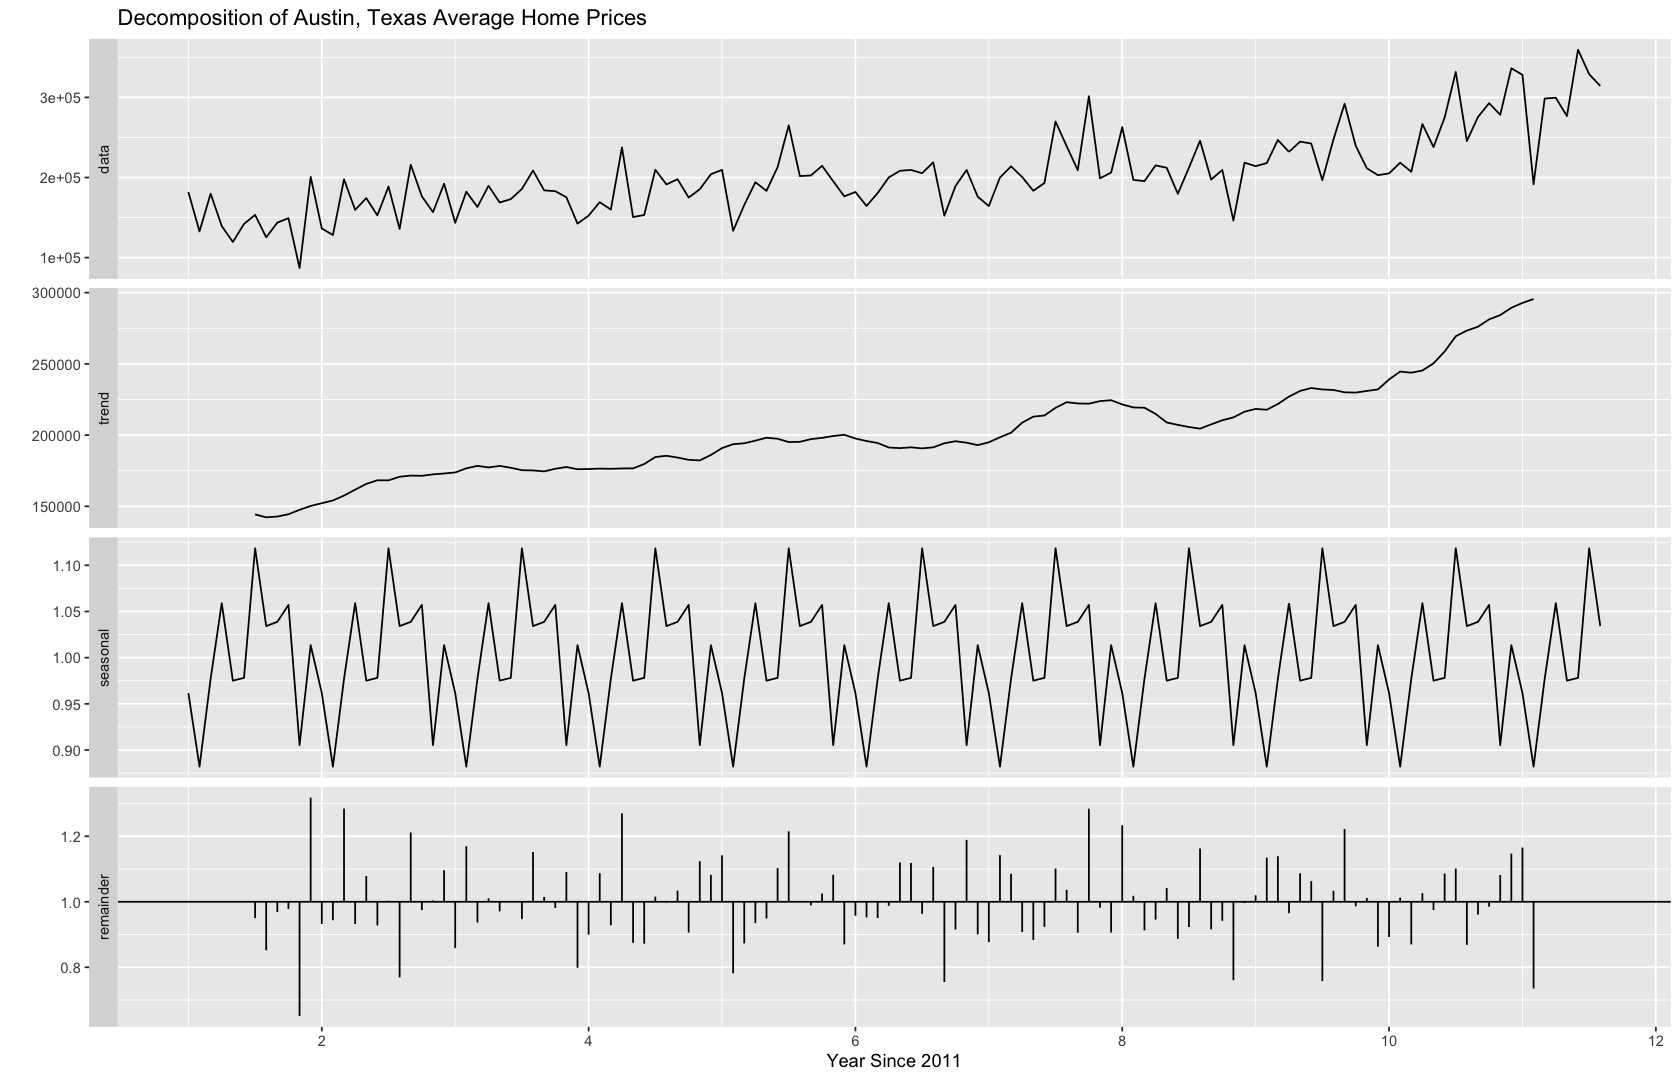

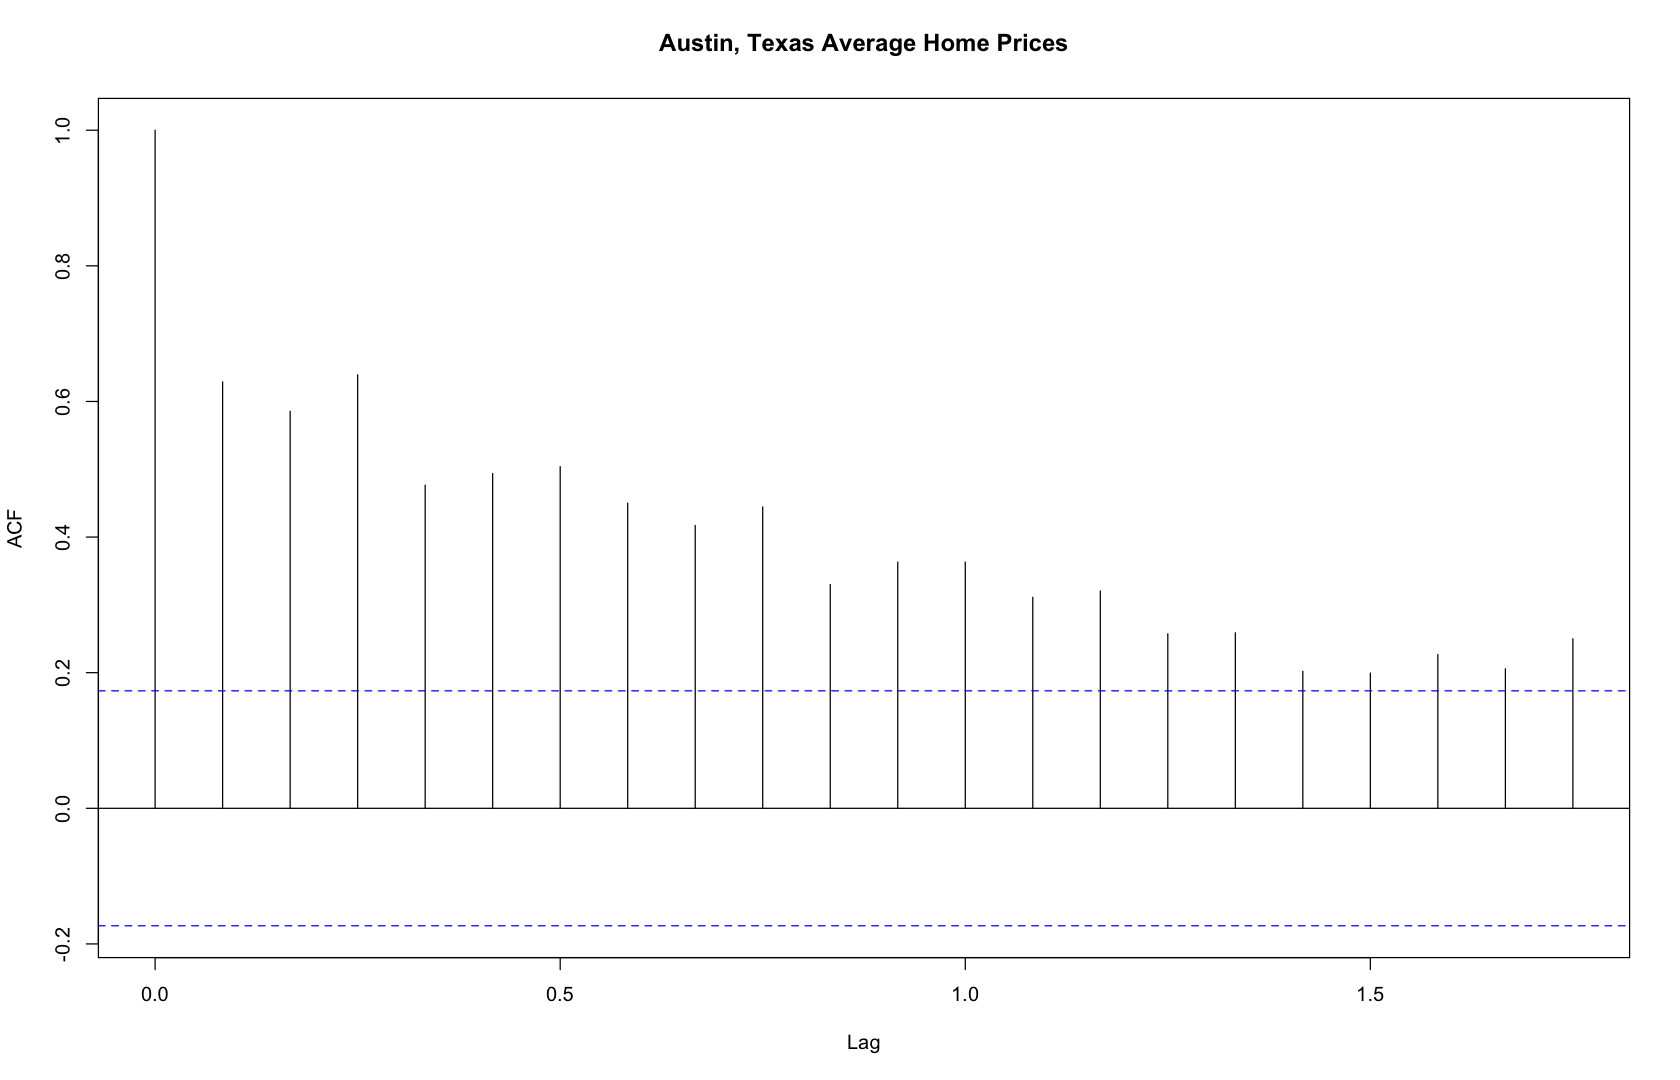

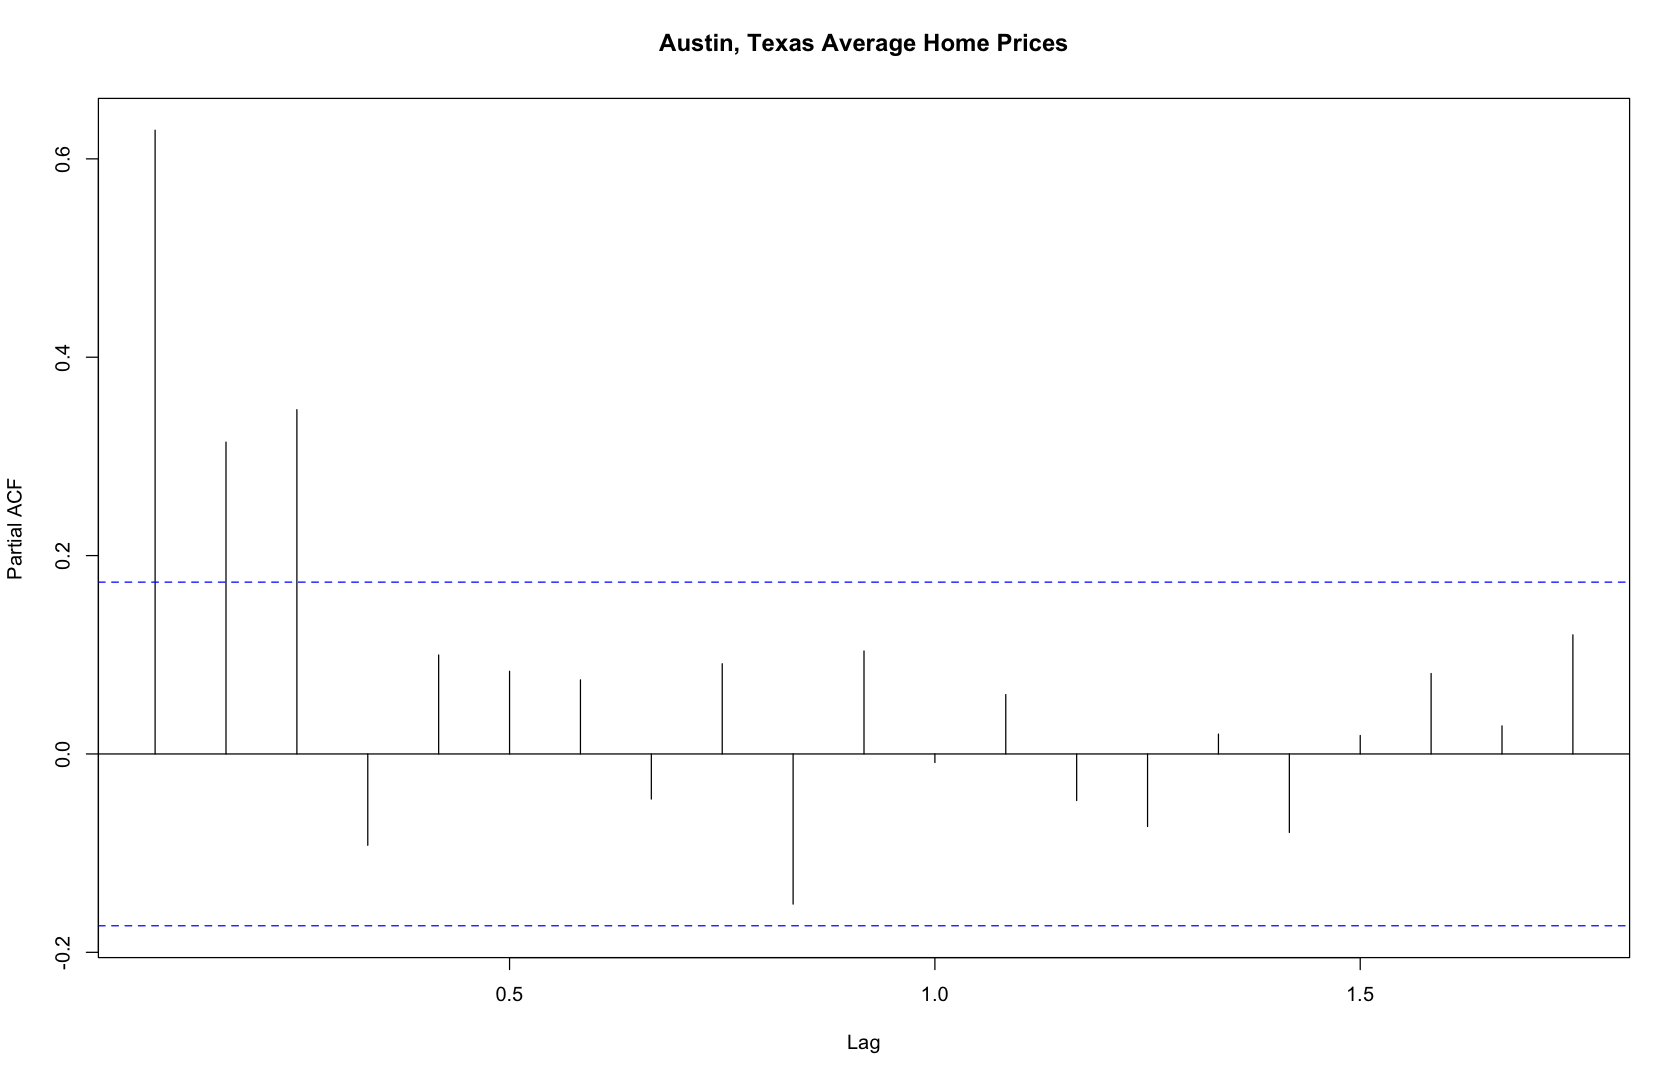

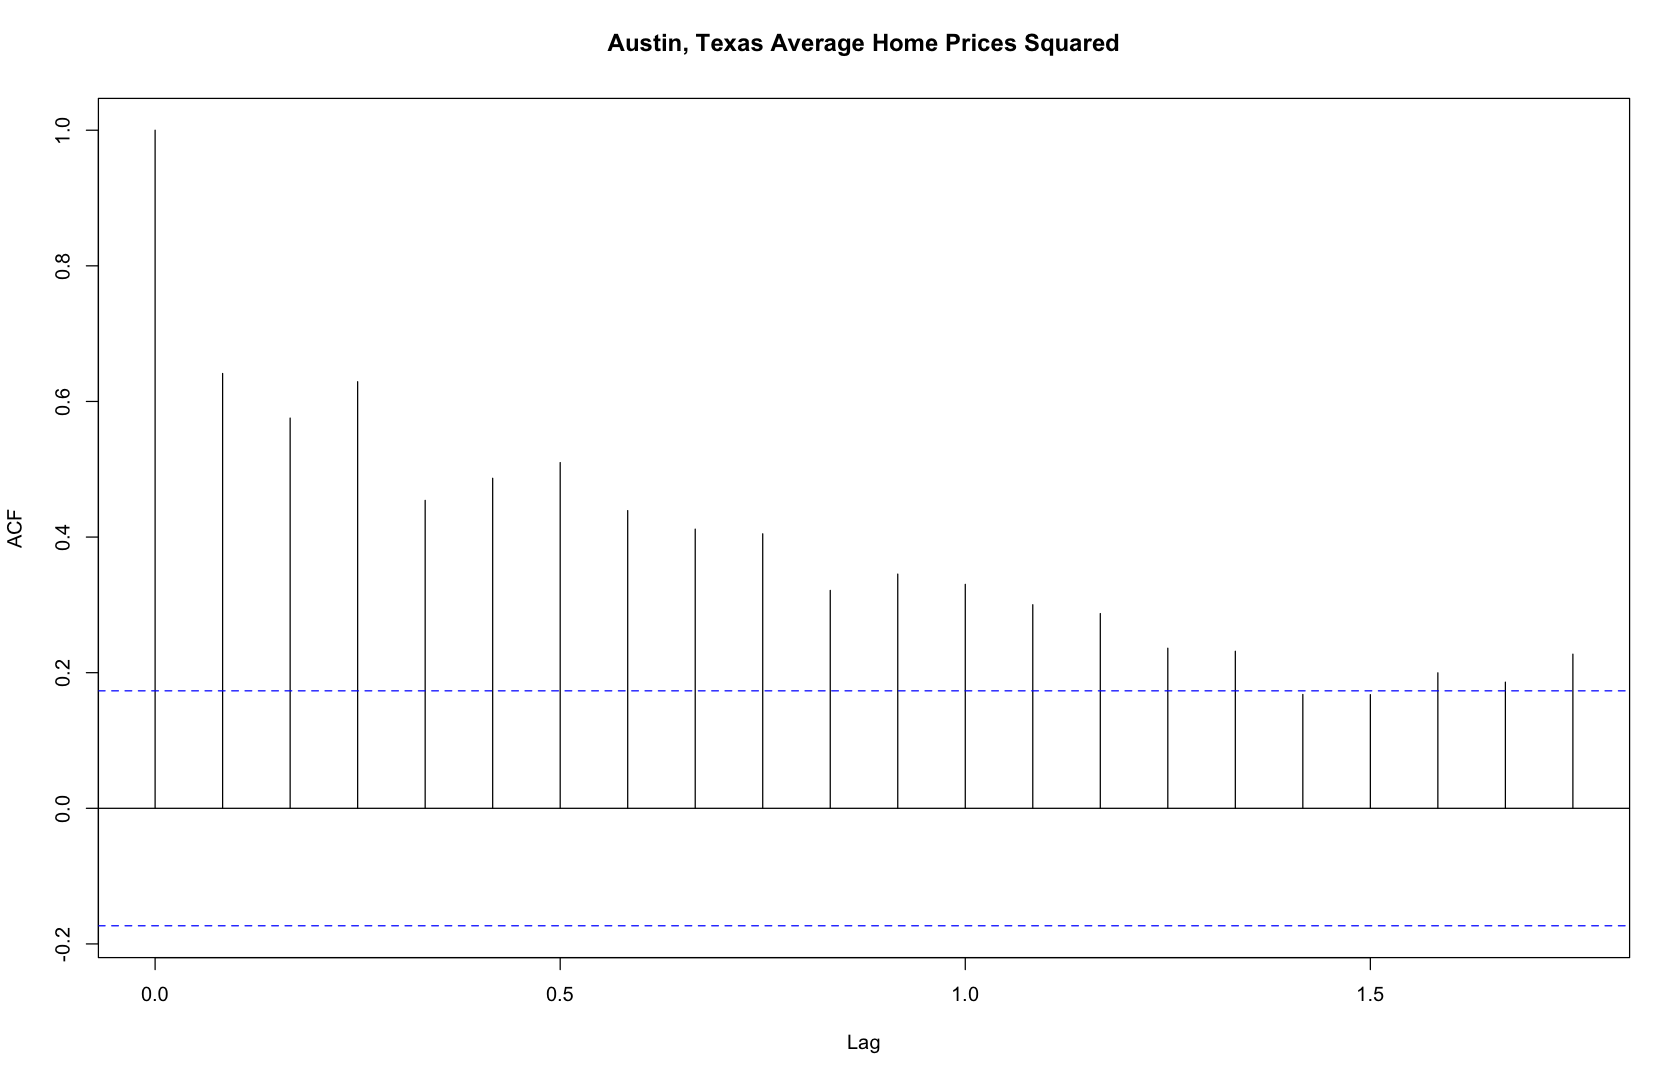

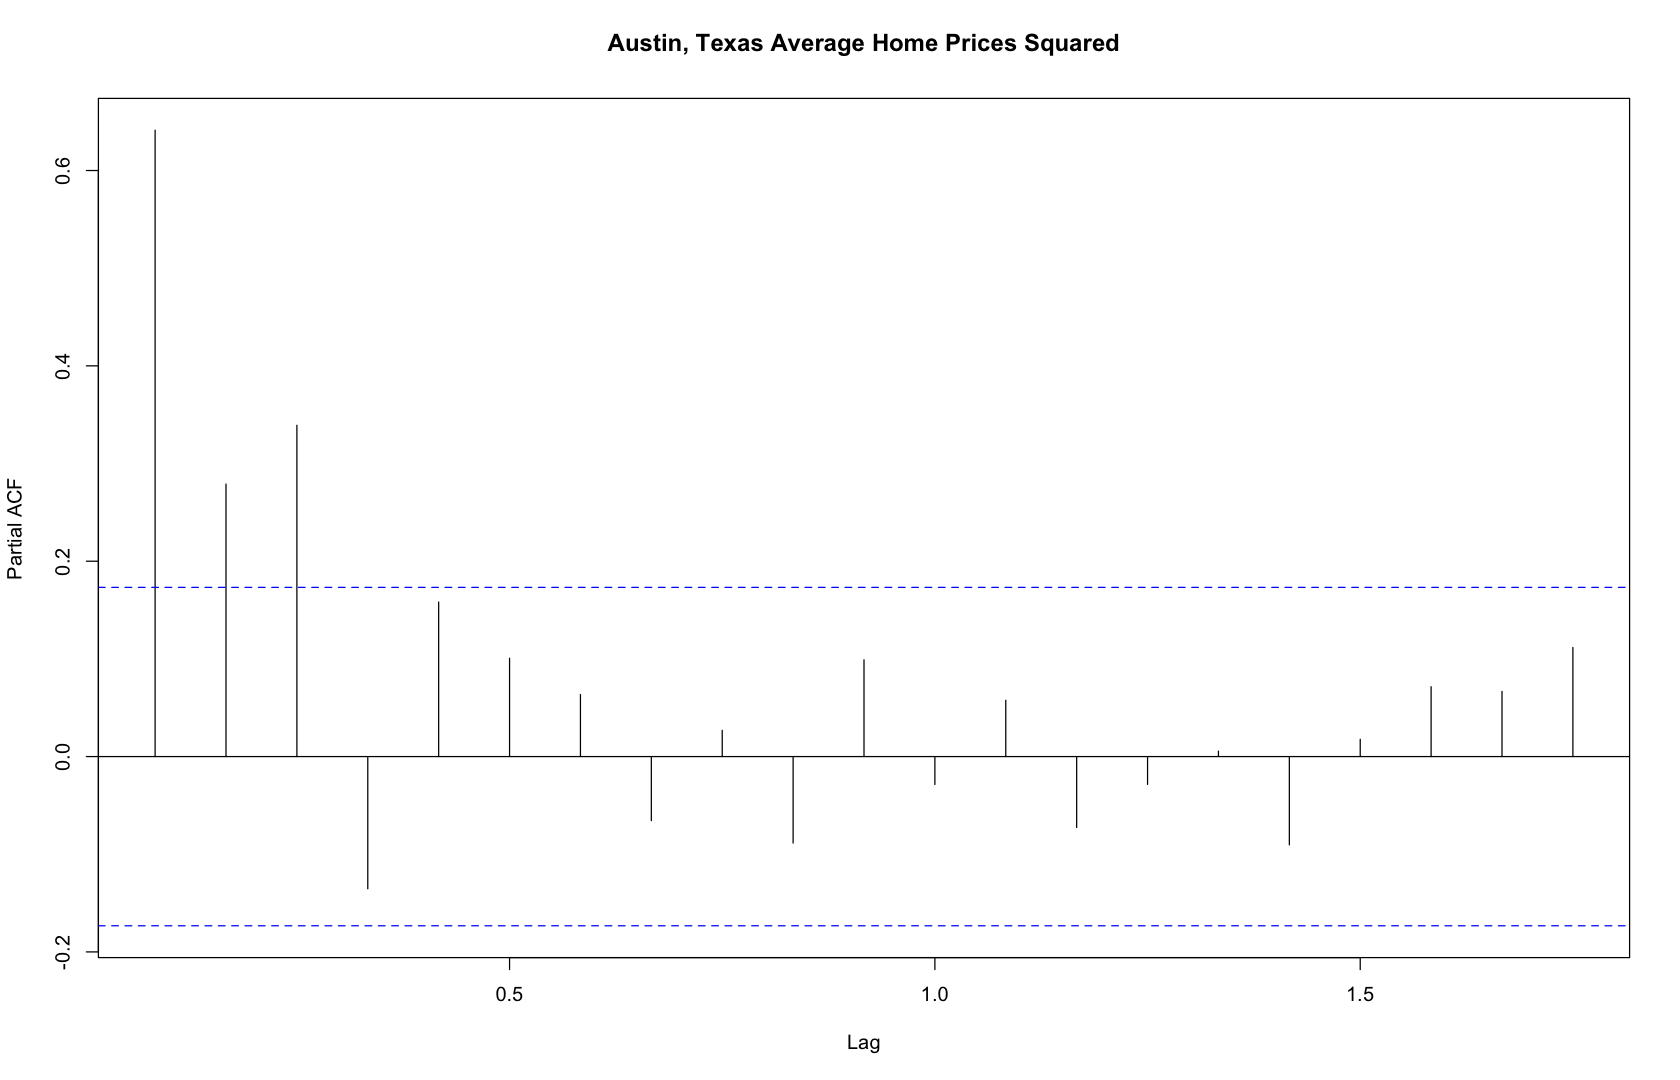

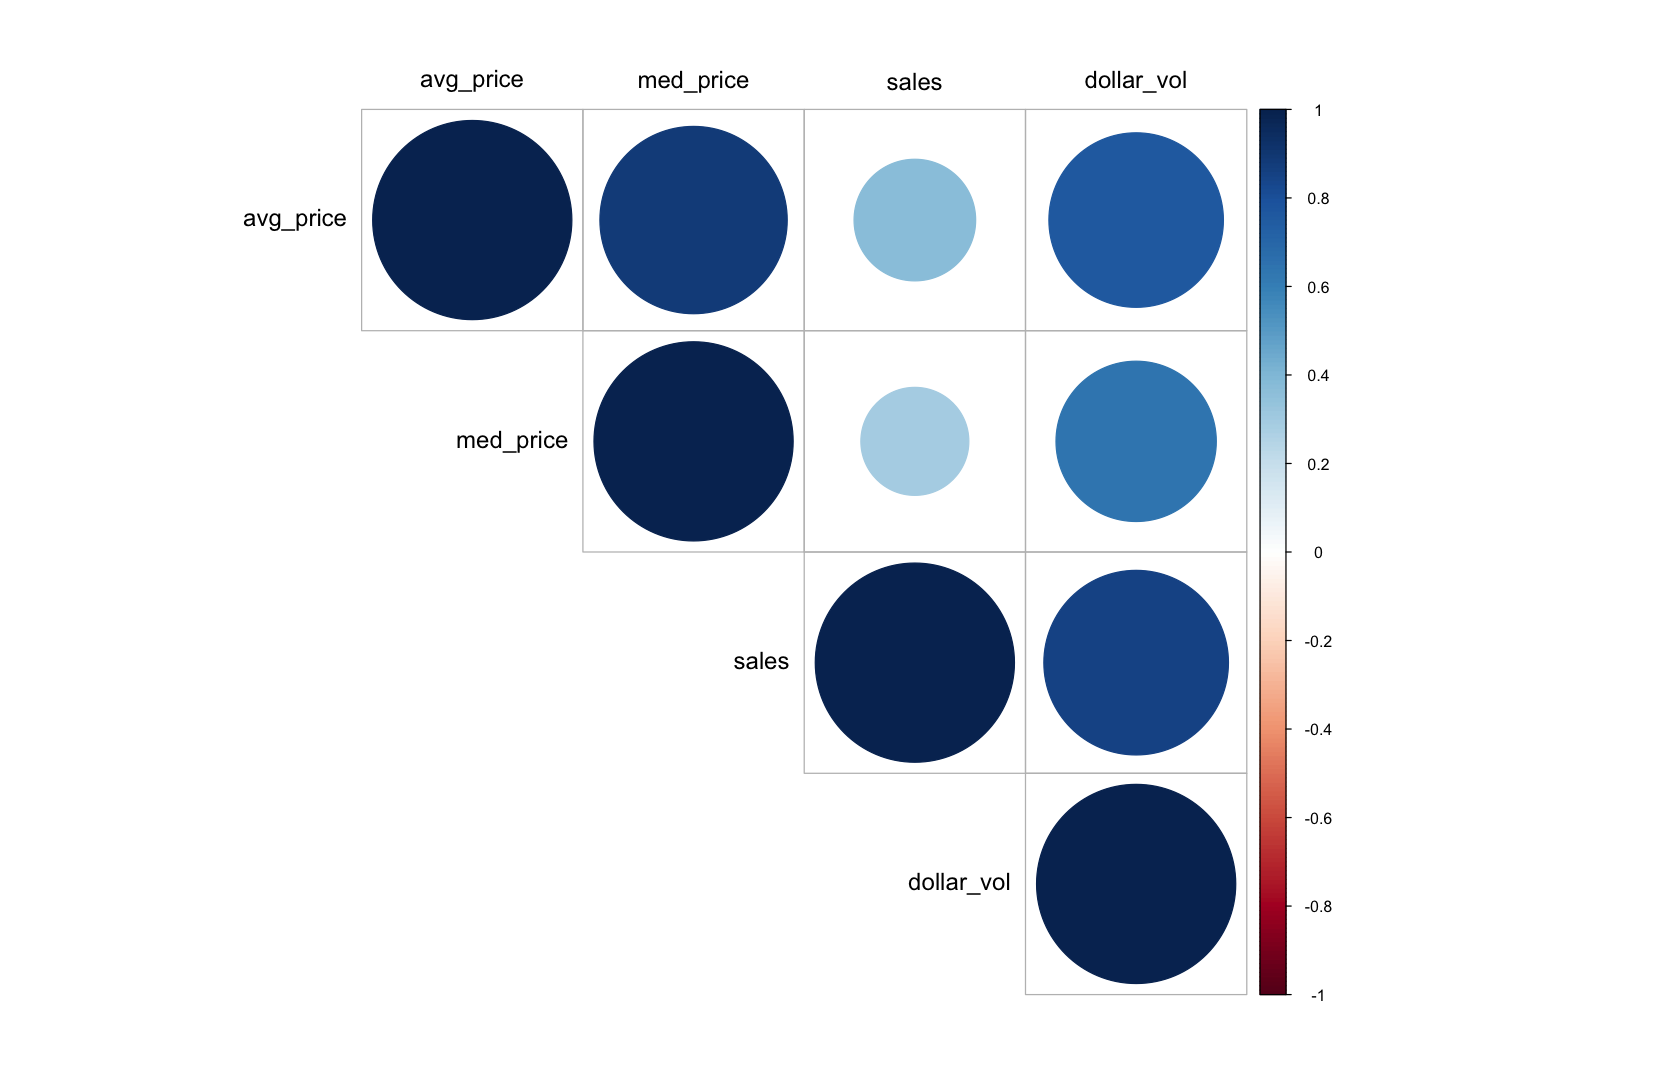

In [50]:
# plotting decomposed time series of austin, tx
austin_decomposed <- decompose(austin_ts, type = 'multiplicative')
autoplot(austin_decomposed) +
labs(x = 'Year Since 2011',
     title = 'Decomposition of Austin, Texas Average Home Prices')

# plotting acf of austin, tx
acf(austin_ts, main = 'Austin, Texas Average Home Prices')

# plotting pacf of austin, tx
pacf(austin_ts, main = 'Austin, Texas Average Home Prices')

# plotting acf of squared observations
acf(austin_ts ^ 2, main = 'Austin, Texas Average Home Prices Squared')

# plotting pacf of squared observations
pacf(austin_ts ^ 2, main = 'Austin, Texas Average Home Prices Squared')



# plotting correlation of features
austin_feats <- df %>% 
filter(county == 'Austin') %>%
select(c('sales', 'dollar_vol', 'avg_price', 'med_price'))

corr_figs <- cor(austin_feats)
par(xpd = TRUE)
corrplot(corr_figs,
         type = 'upper',
         order = 'hclust',
         tl.col = 'black',
         tl.srt = 0.0,
         tl.offset = 0.6, 
         tl.cex = 1.2, 
         mar = c(2, 3, 3, 3))

The series and the squared series both display an AR signature as the PACF sharply cuts off - it doesn't slowly descend. Thus, we would expect here that both the series and the series squared are AR(1) processes for starters. This would imply that we would try a GARCH(1,0) model - i.e. the volatility/variance itself is a AR(1) process. 

The proposed model is then:

$$y_t=\sqrt{a_0+a_1\sigma^2_{t-1}}\epsilon_t$$

which intuitively is what we'd expect - the recent home price volatility dominates the forecast for the following observation. Now, the question is how exactly do we estimate $a_0$ and $a_1$? Well, we can try 1) the MLE and 2) bayesian bs.



# Sources
- "Applied Optimal Estimation" - Arthur Gelb
- "An Introduction to Sequential Monte Carlo" - Chopin and Papaspiliopoulos
- https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-30-feedback-control-systems-fall-2010/lecture-notes/MIT16_30F10_lec05.pdf
- https://people.duke.edu/~rnau/411arim3.htm#plots
- https://otexts.com/fpp2/index.html